In [1]:
from dataclasses import dataclass

from taqsim import (
    Demand,
    Edge,
    LossReason,
    Sink,
    Source,
    Splitter,
    Storage,
    Strategy,
    SumToOne,
    TimeSeries,
    WaterSystem,
)

In [2]:
@dataclass
class NoStorageLoss:
    def calculate(self, node: Storage, t: int, dt: float) -> dict[LossReason, float]:
        return {}


@dataclass
class NoEdgeLoss:
    def calculate(self, edge: Edge, flow: float, t: int, dt: float) -> dict[LossReason, float]:
        return {}


@dataclass
class FixedRelease:
    rate: float

    def release(self, node: Storage, inflow: float, t: int, dt: float) -> float:
        return self.rate


# @dataclass
# class ProportionalSplit:
#     irrigation_share: float = 0.5

#     def split(self, node: Splitter, amount: float, t: int) -> dict[str, float]:
#         irrigation_edge, city_edge = node.targets[0], node.targets[1]
#         return {
#             irrigation_edge: amount * self.irrigation_share,
#             city_edge: amount * (1 - self.irrigation_share),
#         }


@dataclass(frozen=True)
class ProportionalSplit(Strategy):
    irrigation_share: float = 0.5
    city_share: float = 0.5

    __params__ = ("irrigation_share", "city_share")

    __bounds__ = {
        "irrigation_share": (0.0, 1.0),
        "city_share": (0.0, 1.0),
    }

    __constraints__ = (SumToOne(params=("irrigation_share", "city_share")),)

    def split(self, node: Splitter, amount: float, t: int) -> dict[str, float]:
        irrigation_edge, city_edge = node.targets[0], node.targets[1]

        return {
            irrigation_edge: amount * self.irrigation_share,
            city_edge: amount * self.city_share,
        }

In [ ]:
supply = Source(id="supply", inflow=TimeSeries([100.0] * 12), location=(31.77, 35.21))

reservoir = Storage(
    id="reservoir",
    capacity=500,
    release_rule=FixedRelease(rate=80.0),
    loss_rule=NoStorageLoss(),
    location=(31.775, 35.215),
)
splitter = Splitter(id="splitter", split_rule=ProportionalSplit(0.5, 0.5), location=(31.78, 35.22))

irrigation = Demand(id="irrigation", requirement=TimeSeries([30.0] * 12), location=(31.785, 35.225))

city = Demand(id="city", requirement=TimeSeries([40.0] * 12), location=(31.785, 35.215))

irrigation_sink = Sink(id="irrigation_sink", location=(31.79, 35.23))

city_sink = Sink(id="city_sink", location=(31.79, 35.21))

BoundViolationError: Parameter 'irrigation_share' value 1.2 outside bounds [0.0, 1.0]

In [4]:
no_edge_loss = NoEdgeLoss()

e_supply_reservoir = Edge(
    id="e_supply_reservoir", source="supply", target="reservoir", capacity=200, loss_rule=no_edge_loss
)
e_reservoir_splitter = Edge(
    id="e_reservoir_splitter", source="reservoir", target="splitter", capacity=200, loss_rule=no_edge_loss
)
e_splitter_irrigation = Edge(
    id="e_splitter_irrigation", source="splitter", target="irrigation", capacity=100, loss_rule=no_edge_loss
)
e_splitter_city = Edge(id="e_splitter_city", source="splitter", target="city", capacity=100, loss_rule=no_edge_loss)

e_irrigation_sink = Edge(
    id="e_irrigation_sink", source="irrigation", target="irrigation_sink", capacity=100, loss_rule=no_edge_loss
)
e_city_sink = Edge(id="e_city_sink", source="city", target="city_sink", capacity=100, loss_rule=no_edge_loss)

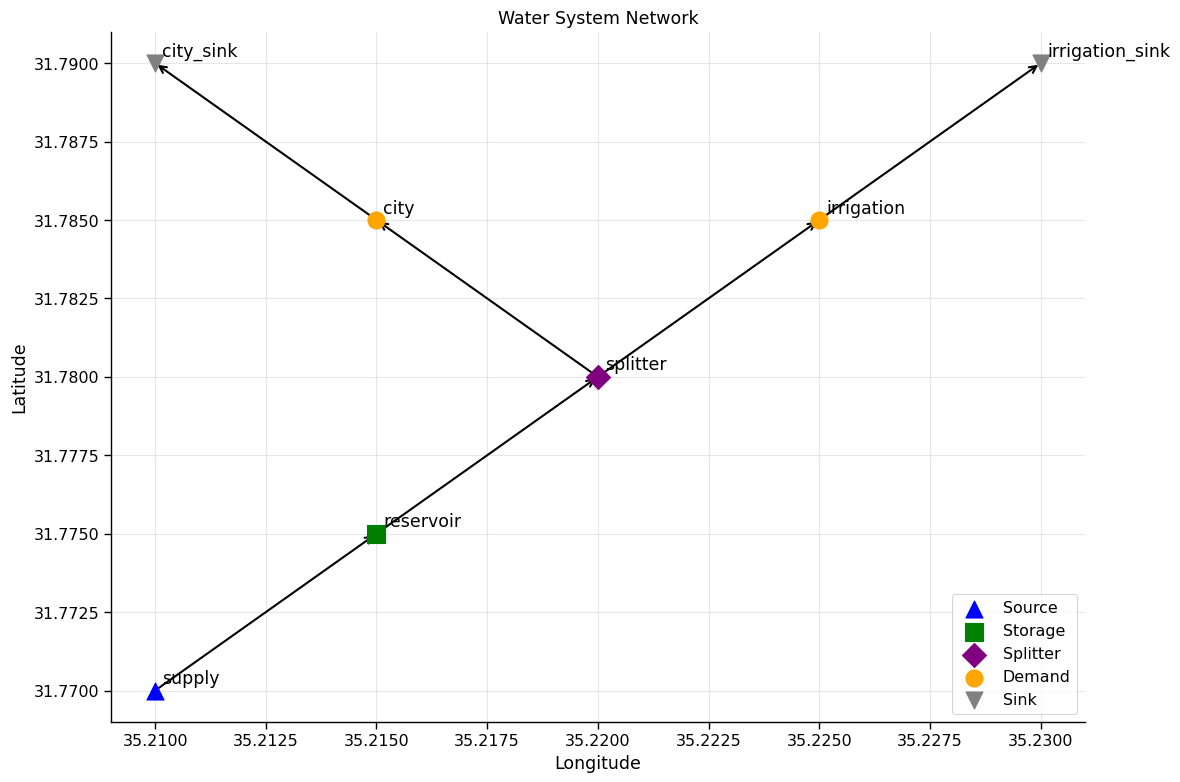

In [6]:
system = WaterSystem(dt=1.0)

for node in [supply, reservoir, splitter, irrigation, city, irrigation_sink, city_sink]:
    system.add_node(node)

for edge in [
    e_supply_reservoir,
    e_reservoir_splitter,
    e_splitter_irrigation,
    e_splitter_city,
    e_irrigation_sink,
    e_city_sink,
]:
    system.add_edge(edge)

system.validate()
system.visualize()

In [ ]:
system.param_schema()

In [ ]:
system.param_bounds()

In [ ]:
system.to_vector()

In [ ]:
system.simulate(timesteps=12)